In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
import PIL

# Домашнее задание №3

Решенный ноутбук нужно загрузить в [форму](http://bit.ly/dafe_hw)  
Дедлайн: __22.05.2019__

## Загрузка данных (5%)

In [3]:
lfw_people = datasets.fetch_lfw_people(
    min_faces_per_person=50, 
    resize=0.4)

Выведите:
- кол-во объектов
- Кол-во признаков
- кол-во классов
- посмотрите, сколько изображений соответствет каждому классу
- Отрисуйте изображения для случайных семплов с подписями имен класса 

кол-во объектов 1560
Кол-во признаков 1850
кол-во классов 12
{0: 77, 1: 236, 2: 121, 3: 530, 4: 109, 5: 71, 6: 52, 7: 55, 8: 53, 9: 60, 10: 52, 11: 144}


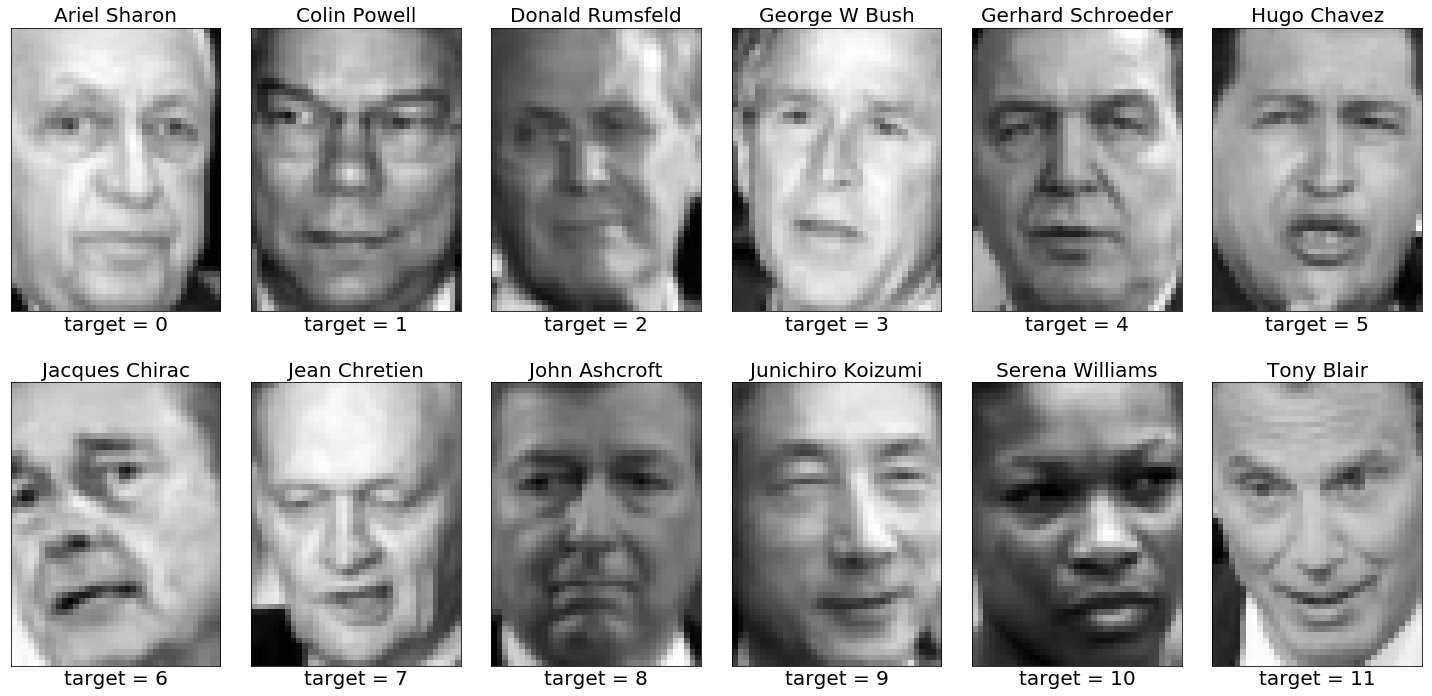

In [4]:
# Ваш код здесь
print('кол-во объектов', lfw_people.data.shape[0])
print('Кол-во признаков', lfw_people.data.shape[1])
num_classes = len(set(lfw_people.target))
print('кол-во классов', num_classes)
unique, counts = np.unique(lfw_people.target, return_counts=True)
print(dict(zip(unique, counts)))

pic_to_idx = {idx:i for i, idx in enumerate(lfw_people.target)}

fig, ax = plt.subplots(nrows = 2, ncols = 6, figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(num_classes):
    ax[i].imshow(lfw_people.images[pic_to_idx.get(i)], cmap='gray')
    ax[i].set_title(lfw_people.target_names[i], fontsize=20)
    ax[i].set_xlabel('target = {}'.format(i), fontsize=20)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
plt.tight_layout()
plt.show()

## Пора учить нейронки! (5%) 

In [5]:
from keras.models import Sequential 
from keras.layers import Dense, Flatten, Activation, Conv2D, MaxPooling2D, Dropout 
from keras.utils import np_utils
from keras.optimizers import Adam

Using TensorFlow backend.


In [6]:
# Конечно мы сначала должны нормировать и центрировать данные: 
mean, std = lfw_people.data.mean(), lfw_people.data.std()
x = (lfw_people.data - mean) / std
y = lfw_people.target

# используйте lfw_people.target и lfw_people.images

In [7]:
def indices_to_one_hot(data, nb_classes):
    """one-hot-encoding"""
    targets = np.array(data).reshape(-1)
    return np.eye(nb_classes)[targets]

y_ohe = indices_to_one_hot(y, num_classes)

In [8]:
# Разделим данные на трейн/валидацию/тест: 
x_train, x_test, y_train_cat, y_test_cat = train_test_split(x, y_ohe, 
                                                            train_size=0.6, 
                                                            test_size=0.4, 
                                                            random_state=42)
x_val, x_test, y_val_cat, y_test_cat = train_test_split(x_test, y_test_cat, 
                                                        train_size=0.5, 
                                                        test_size=0.5, 
                                                        random_state=42)

# Cделайте one-hot-encoding для целевой переменной

## Fully connected neural network (20%)
Создадим нашу первую модель, будем использовать полносвязную нейронную сеть 
- Первый слой (входной): 64 нейрона, функция активации ReLU
- Скрытый слой: 32 нейрона, функция активации ReLU
- Чтобы наша сеть не переобучалась, после каждого полно-связного используйте слой Dropout с параметром rate = 0.4
- Выходной слой: на ваше усмотрение :) 

Будем обучать с помощью Adam на 100 эпохах,  размер сэмпла для минибатча: 10

Учимся на train, валидируем на val

In [9]:
input_shape = x_test[0, :].shape
epochs = 100
batch_size = 10
steps = 300

### Generator (threads)

In [10]:
import threading

class threadsafe_iter:
    """
    Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self):
        with self.lock:
            return next(self.it)
        
def threadsafe_generator(f):
    """
    A decorator that takes a generator function and makes it thread-safe.
    """
    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))
    return g

In [11]:
@threadsafe_generator
def make_image_gen_cat(in_df, batch_size=batch_size):
    out_map = []
    out_class = []
    x, y = in_df
    indexes = np.random.randint(0, x.shape[0], x.shape[0])
    while True:
        for index in indexes:
            out_map += [x[index]]
            out_class += [y[index]]
            if len(out_map) >= batch_size:
                out_map = np.array(out_map)
                out_class = np.array(out_class)
                out_map = out_map.reshape(out_map.shape[0], input_shape[0])
                yield np.stack(out_map, 0), out_class
                out_map = []
                out_class = []

In [12]:
valid_x, valid_y = next(make_image_gen_cat((x_test, y_test_cat)))
print(valid_x.shape, valid_y.shape)

(10, 1850) (10, 12)


In [13]:
model = Sequential()
model.add(Dense(64, input_shape=input_shape))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

opt = Adam()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                118464    
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
activation_2 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 12)                396       
__________

In [15]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

weight_path='easy_weights.h5'

checkpoint = ModelCheckpoint(weight_path, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_acc', factor=0.33,
                                   patience=3, verbose=1, mode='max',
                                   min_delta=0.0001, cooldown=0, min_lr=1e-6)

early = EarlyStopping(monitor="val_acc", mode="max", verbose=2, 
                      patience=7)



callbacks_list = [checkpoint, reduceLROnPlat, early]

In [16]:
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
gen_train_cat = make_image_gen_cat((x_train, y_train_cat))
gen_valid_cat = make_image_gen_cat((x_val, y_val_cat))

history = model.fit_generator(gen_train_cat,
                              steps_per_epoch=steps,
                              validation_data=gen_valid_cat,
                              validation_steps=100,
                              epochs=epochs,
                              callbacks=callbacks_list,
                              workers=16,
                              verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
300/300 [==============================] - 6s 22ms/step - loss: 2.1917 - acc: 0.3043 - val_loss: 1.7545 - val_acc: 0.4170

Epoch 00001: val_acc improved from -inf to 0.41700, saving model to easy_weights.h5
Epoch 2/100
300/300 [==============================] - 2s 8ms/step - loss: 1.6162 - acc: 0.4783 - val_loss: 1.4918 - val_acc: 0.5330

Epoch 00002: val_acc improved from 0.41700 to 0.53300, saving model to easy_weights.h5
Epoch 3/100
300/300 [==============================] - 2s 8ms/step - loss: 1.3052 - acc: 0.5727 - val_loss: 1.3079 - val_acc: 0.5850

Epoch 00003: val_acc improved from 0.53300 to 0.58500, saving model to easy_weights.h5
Epoch 4/100
300/300 [==============================] - 2s 8ms/step - loss: 1.1220 - acc: 0.6330 - val_loss: 1.4113 - val_acc: 0.5390

Epoch 00004: val_acc did not improve from 0.58500
Epoch 5/100
300/300 [==============================] - 2s 7ms/step - loss: 1.0005 - acc: 0.6683 - val_loss:

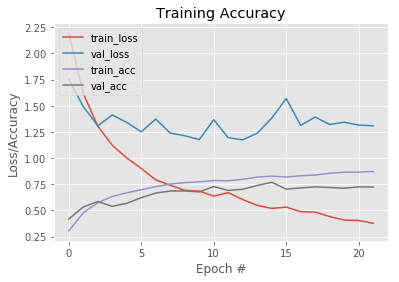

In [18]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
N = len(history.epoch)
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
# plot the trainingaccuracy
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left");

Постройте confusion_matrix (используйте sklearn) на тестовой выборке (test) и посчитайте долю правильных ответов(test)

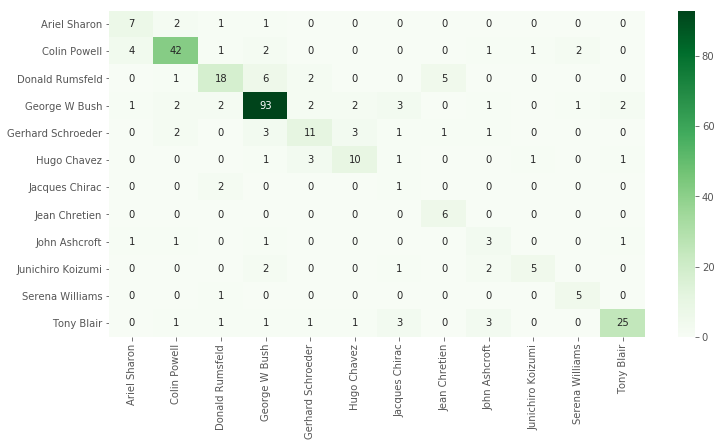

In [19]:
y_pred = model.predict(x_test).argmax(axis=1)
y_true = y_test_cat.argmax(axis=1)
confusionmatrix = confusion_matrix(y_pred, y_true)

plt.figure(figsize=(12, 6))
sns.heatmap(confusionmatrix, cmap='Greens', annot=True,
            xticklabels=lfw_people.target_names,
            yticklabels=lfw_people.target_names)
plt.show()

Оцените, кого с кем вы чаще всего путаете? Почему одних людей наша сеть путает с другими чаще?

__Ответ:__ В данном случае выходит, что Donald Rumsfeld путается с другими чаще остальных. Это происходит, возможно, из-за ракурсов фото, освещения и прочих аугментационных вещей. Наверное, у данной персоны больше всего корреляция этих параметров со всеми другими. 

Вспомним, что в нашей задачи классы, не сбалансированы, какая получится доля правильных ответов, если мы всегда будем предсказывать константнам значением: George W Bush

In [20]:
y_Bush = np.ones(y_true.shape) * np.where(lfw_people.target_names == 'George W Bush')[0][0]
accuracy_Bush = accuracy_score(y_Bush, y_true)
accuracy = accuracy_score(y_pred, y_true)

print('Доля верных ответов на всем тесте: %.2f' % accuracy)
print('Доля верных ответов на константе George W Bush: %.2f' % accuracy_Bush)

Доля верных ответов на всем тесте: 0.72
Доля верных ответов на константе George W Bush: 0.35


## Это же картинки! Попробуем Convolution neural network (30%)

- Используйте два сверточных слоя (по 16 нейронов с функцией активации ReLu, padding='same')
- Затем слой MaxPooling'a с размерром 2х2
- Затем полносвязные слои: 32 нейрона и 16 нейронов
- Выходной слой как раньше 

Помните о требованиях свертки к размерности входных данных и используйте `.reshape`

In [196]:
input_shape = lfw_people.images.shape[1:]
epochs = 100
batch_size = 50
steps = 100

In [197]:
x = lfw_people.images
x_train, x_test, y_train_cat, y_test_cat = train_test_split(x, y_ohe, 
                                                            train_size=0.6, 
                                                            test_size=0.4, 
                                                            random_state=42)
x_val, x_test, y_val_cat, y_test_cat = train_test_split(x_test, y_test_cat, 
                                                        train_size=0.5, 
                                                        test_size=0.5, 
                                                        random_state=42)

In [198]:
import random

@threadsafe_generator
def make_image_gen_cat_conv(in_df, batch_size=batch_size):
    out_map = []
    out_class = []
    x, y = in_df
    indexes = random.sample(range(x.shape[0]), batch_size)
    while True:
        for index in indexes:
            out_map += [x[index]/255.]
            out_class += [y[index]]
            if len(out_map) >= batch_size:
                out_map = np.array(out_map)
                out_class = np.array(out_class)
                out_map = out_map.reshape(out_map.shape[0], input_shape[0], input_shape[1], 1)
                yield np.stack(out_map, 0), out_class
                out_map = []
                out_class = []

In [199]:
valid_x, valid_y = next(make_image_gen_cat_conv((x_test, y_test_cat)))
print(valid_x.shape, valid_y.shape)

(50, 50, 37, 1) (50, 12)


In [200]:
class small_conv_net:
    @staticmethod
    def build(classes, finalAct="softmax"):
        model = Sequential()
        
        model.add(Conv2D(16, (3, 3), padding="same", 
                 input_shape=(input_shape[0], input_shape[1], 1)))
        model.add(Activation('relu'))
        model.add(Conv2D(16, (3, 3), padding="same"))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.4))

        model.add(Flatten())
        model.add(Dense(32))
        model.add(Activation('relu'))
        model.add(Dense(16))
        model.add(Activation('relu'))
        model.add(Dropout(0.4))
        
        model.add(Dense(classes))
        model.add(Activation(finalAct))

        return model

model_conv = small_conv_net.build(classes=num_classes, finalAct="softmax")
opt = Adam(lr=1e-3)

In [60]:
model_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 50, 37, 16)        160       
_________________________________________________________________
activation_14 (Activation)   (None, 50, 37, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 50, 37, 16)        2320      
_________________________________________________________________
activation_15 (Activation)   (None, 50, 37, 16)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 25, 18, 16)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 25, 18, 16)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 7200)              0         
__________

In [61]:
weight_path='easy_conv.h5'

checkpoint = ModelCheckpoint(weight_path, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_acc', factor=0.33,
                                   patience=3, verbose=1, mode='max',
                                   min_delta=0.0001, cooldown=0, min_lr=1e-6)

early = EarlyStopping(monitor="val_acc", mode="max", verbose=2, 
                      patience=7)



callbacks_list = [checkpoint, reduceLROnPlat, early]

In [62]:
model_conv.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)
            
reset_weights(model_conv)

In [63]:
gen_train_cat = make_image_gen_cat_conv((x_train, y_train_cat), batch_size=100)
gen_valid_cat = make_image_gen_cat_conv((x_val, y_val_cat), batch_size=100)

history = model_conv.fit_generator(gen_train_cat,
                                   steps_per_epoch=steps,
                                   validation_data=gen_valid_cat,
                                   validation_steps=100,
                                   epochs=epochs,
                                   callbacks=callbacks_list,
                                   workers=16,
                                   verbose=1)

Epoch 1/100
100/100 [==============================] - 3s 27ms/step - loss: 1.8077 - acc: 0.3917 - val_loss: 1.9417 - val_acc: 0.3600

Epoch 00001: val_acc improved from -inf to 0.36000, saving model to easy_conv.h5
Epoch 2/100
100/100 [==============================] - 2s 20ms/step - loss: 0.7662 - acc: 0.7206 - val_loss: 2.2872 - val_acc: 0.5100

Epoch 00002: val_acc improved from 0.36000 to 0.51000, saving model to easy_conv.h5
Epoch 3/100
100/100 [==============================] - 2s 19ms/step - loss: 0.3743 - acc: 0.8606 - val_loss: 2.4706 - val_acc: 0.5000

Epoch 00003: val_acc did not improve from 0.51000
Epoch 4/100
100/100 [==============================] - 2s 19ms/step - loss: 0.2635 - acc: 0.8960 - val_loss: 3.2731 - val_acc: 0.4900

Epoch 00004: val_acc did not improve from 0.51000
Epoch 5/100
100/100 [==============================] - 2s 18ms/step - loss: 0.2265 - acc: 0.9063 - val_loss: 3.0601 - val_acc: 0.5200

Epoch 00005: val_acc improved from 0.51000 to 0.52000, savin

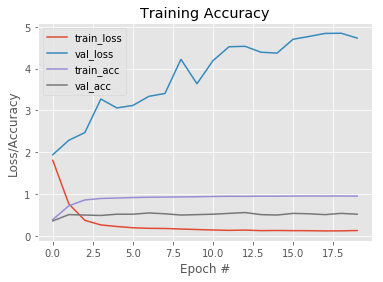

In [64]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
N = len(history.epoch)
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
# plot the trainingaccuracy
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left");

Постройте confusion_matrix (используйте sklearn) на тестовой выборке (test) и посчитайте долю правильных ответов(test)

Доля верных ответов на всем тесте: 0.42


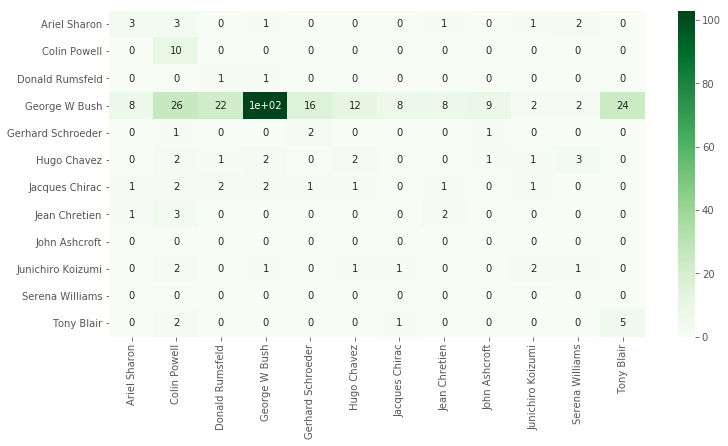

In [65]:
y_pred = model_conv.predict(x_test.reshape(x_test.shape[0], input_shape[0], input_shape[1], 1)).argmax(axis=1)
y_true = y_test_cat.argmax(axis=1)
confusionmatrix = confusion_matrix(y_pred, y_true)

accuracy = accuracy_score(y_pred, y_true)
print('Доля верных ответов на всем тесте: %.2f' % accuracy)

plt.figure(figsize=(12, 6))
sns.heatmap(confusionmatrix, cmap='Greens', annot=True,
            xticklabels=lfw_people.target_names,
            yticklabels=lfw_people.target_names)
plt.show()

Кажется, что стало лучше, но постройте график зависимости доли правильных ответов от эпохи на обучении и валидации. Какие выводы можно сделать?  

### Ваши ответы здесь

Переобучение ¯¯\_(ツ)_/¯¯ 

## Aугментация дынных (40%)
Вспомним, что для борьбы с переобучением, нам может помочь Aугментация, для этого мы будем использовать стандартные возможности Keras. Загляните в [доку](https://keras.io/preprocessing/image/) или в эту [статью](https://towardsdatascience.com/image-augmentation-for-deep-learning-using-keras-and-histogram-equalization-9329f6ae5085) 

Вы можете использовать любые аугментации

In [201]:
from keras.preprocessing.image import ImageDataGenerator

dg_args = dict(featurewise_center = False, 
               samplewise_center = False,
               horizontal_flip=True,
               rotation_range = 15, 
               brightness_range=[0.9, 1.1],
               shear_range = 0.01,
               width_shift_range = 0.1, 
               height_shift_range = 0.1)

dg_args = dict(
               horizontal_flip=True,
               rotation_range = 5)


image_gen = ImageDataGenerator(**dg_args)
@threadsafe_generator
def create_aug_gen(in_gen):
    for in_x, in_y in in_gen:
        g_x = image_gen.flow(255*in_x, 
                             batch_size=in_x.shape[0])
        yield next(g_x)/255., in_y

(50, 50, 37, 1) (50, 12)


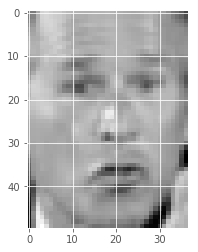

In [202]:
valid_x, valid_y = next(create_aug_gen(make_image_gen_cat_conv((x_test, y_test_cat))))
print(valid_x.shape, valid_y.shape)

test = valid_x[0,:,:,0]
plt.imshow(test, cmap='gray')

In [158]:
weight_path='easy_conv.h5'

checkpoint = ModelCheckpoint(weight_path, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_acc', factor=0.33,
                                   patience=3, verbose=1, mode='max',
                                   min_delta=0.0001, cooldown=0, min_lr=1e-6)

early = EarlyStopping(monitor="val_acc", mode="max", verbose=2, 
                      patience=7)



callbacks_list = [checkpoint, reduceLROnPlat, early]

In [159]:
model_conv = small_conv_net.build(classes=num_classes, finalAct="softmax")
opt = Adam(lr=1e-3)
model_conv.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)
            
reset_weights(model_conv)

In [160]:
image_gen.fit(x_train.reshape((x_train.shape[0], 50, 37, 1)))
gen_valid_cat = make_image_gen_cat_conv((x_val, y_val_cat), batch_size=32)

history = model_conv.fit_generator(image_gen.flow(x_train.reshape((x_train.shape[0], 50, 37, 1)), 
                                                  y_train_cat, 
                                                  batch_size=32),
                                   epochs=50,
                                   steps_per_epoch=100,
                                   validation_data=gen_valid_cat,
                                   validation_steps=50)

Epoch 1/50
100/100 [==============================] - 3s 26ms/step - loss: 12.2677 - acc: 0.2316 - val_loss: 2.4406 - val_acc: 0.0312
Epoch 2/50
100/100 [==============================] - 1s 13ms/step - loss: 6.3726 - acc: 0.2434 - val_loss: 2.3305 - val_acc: 0.5000
Epoch 3/50
100/100 [==============================] - 1s 13ms/step - loss: 2.2233 - acc: 0.3159 - val_loss: 2.2437 - val_acc: 0.5000
Epoch 4/50
100/100 [==============================] - 1s 13ms/step - loss: 2.1459 - acc: 0.3184 - val_loss: 2.1838 - val_acc: 0.5000
Epoch 5/50
100/100 [==============================] - 1s 13ms/step - loss: 2.0378 - acc: 0.3522 - val_loss: 2.1521 - val_acc: 0.5000
Epoch 6/50
100/100 [==============================] - 1s 13ms/step - loss: 1.9044 - acc: 0.4016 - val_loss: 2.1572 - val_acc: 0.5000
Epoch 7/50
100/100 [==============================] - 1s 14ms/step - loss: 1.8027 - acc: 0.4356 - val_loss: 2.1491 - val_acc: 0.5000
Epoch 8/50
100/100 [==============================] - 1s 13ms/step -

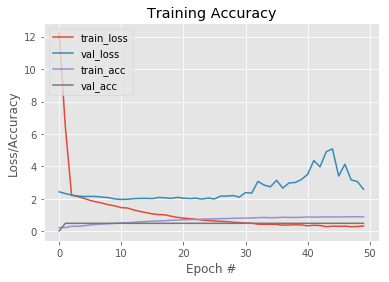

In [161]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
N = len(history.epoch)
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
# plot the trainingaccuracy
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left");

Доля верных ответов на всем тесте: 0.86


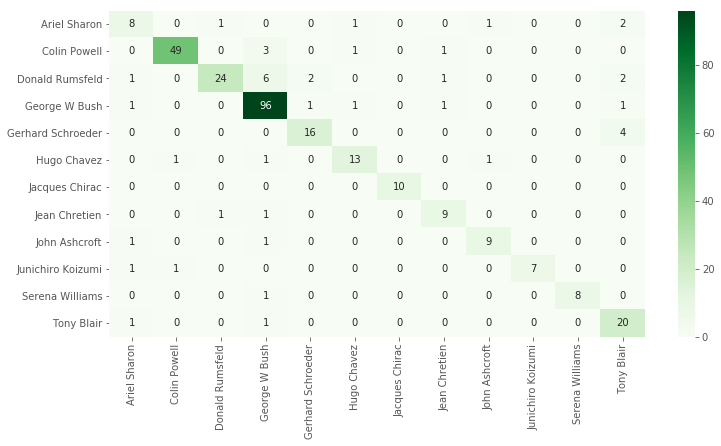

In [162]:
y_pred = model_conv.predict(x_test.reshape(x_test.shape[0], input_shape[0], input_shape[1], 1)).argmax(axis=1)
y_true = y_test_cat.argmax(axis=1)
confusionmatrix = confusion_matrix(y_pred, y_true)

accuracy = accuracy_score(y_pred, y_true)
print('Доля верных ответов на всем тесте: %.2f' % accuracy)

plt.figure(figsize=(12, 6))
sns.heatmap(confusionmatrix, cmap='Greens', annot=True,
            xticklabels=lfw_people.target_names,
            yticklabels=lfw_people.target_names)
plt.show()

Посмотрите долю правильных ответов на тестовой выборке и постройте график зависимости от эпох для обучения и валидации
Ответьте на вопросы и объясните свой ответ: 
- Удалось ли Вам победить переобучение? 
- Будет ли полезна аугментация horizontal_flip?

### Ваши ответы здесь

1. Да, переобучение удалось побить.

2. Черезмерная аугментация вредит. Например, использавать изменение зума, яркости и больших углов поворта ~ 10-15 все ломает из--за того, что в тесте таких сэмплов нет. 

__Основная сложность получилось в том, что я очень долго искал причину того, почему мой собственны генератор давал мне переобучение, не смотря на очень сильную аугментаци. Плюс к этому валидационные данные вели к пермаментному переобучению. Фикс получился в том, чтобы исключить собственный генератор - все сделал через генератор ImageDataGenerator - и убрал валидацию. Все заработало. Пока не понял почему была проблема.__
¯¯\_(ツ)_/¯¯ 

## Дополнительное задание (дополнительные +30%) 
Обучите такую нейронную сеть, чтобы на тестовой выборке достичь доли правильных ответов больше 92%

In [228]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
from keras.utils import np_utils
import keras

In [229]:
lfw_people = datasets.fetch_lfw_people(
    min_faces_per_person=50, 
    resize=0.4)

data = [[d] for d in lfw_people.images]

df = pd.DataFrame(data, columns=['Image'])
df['Target'] = lfw_people.target
mapping_type = {i:name for i, name in enumerate(lfw_people.target_names)}
df['Name'] = df.Target.replace({'Target':mapping_type}) 
df = df.replace({'Name':mapping_type})
df.head()

,Image,Target,Name
0,"[[83.0, 91.666664, 112.0, 101.666664, 92.0, 11...",11,Tony Blair
1,"[[38.666668, 69.666664, 84.666664, 91.0, 97.0,...",4,Gerhard Schroeder
2,"[[82.666664, 58.0, 59.0, 66.333336, 71.666664,...",2,Donald Rumsfeld
3,"[[141.66667, 139.33333, 112.0, 91.0, 96.666664...",3,George W Bush
4,"[[89.666664, 96.666664, 90.0, 95.0, 142.0, 163...",3,George W Bush


<Figure size 432x216 with 0 Axes>

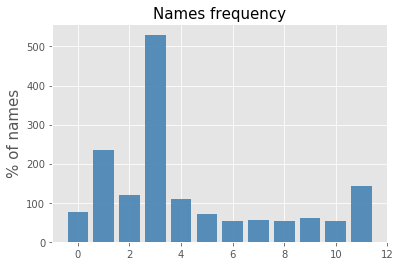

In [230]:
import matplotlib.pyplot as plt

uni_names = np.unique(df.Target, return_counts=True)

plt.figure(figsize=(6,3))
fig, ax = plt.subplots()
ax.bar(uni_names[0], uni_names[1],
            color='steelblue', align='center', alpha=0.9)
ax.set_title("Names frequency", fontsize=15)
ax.set_ylabel("% of names", fontsize=15)
plt.show();

In [231]:
np.random.seed(42)
 
remove_n = 300
drop_indices = np.random.choice(df.Target[df.Target == 3].index, remove_n, replace=False)
df_subset = df.drop(drop_indices)

In [232]:
input_shape = lfw_people.images.shape[1:]
epochs = 200
BATCH = 10
steps = 100

In [240]:
class small_vgg:
    @staticmethod
    def build(classes, finalAct="softmax"):
        model = Sequential()
        
        model.add(Conv2D(32, (5, 5), padding="same", 
                 input_shape=(input_shape[0], input_shape[1], 1)))
        model.add(Activation(activation=keras.layers.LeakyReLU(alpha=0.1)))
        model.add(BatchNormalization())
        model.add(Conv2D(32, (5, 5), padding="same"))
        model.add(Activation(activation=keras.layers.LeakyReLU(alpha=0.1)))
        model.add(BatchNormalization())
        model.add(Conv2D(64, (5, 5), padding="same"))
        model.add(Activation(activation=keras.layers.LeakyReLU(alpha=0.1)))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.4))

        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.4))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(100))
        model.add(Activation(activation=keras.layers.LeakyReLU(alpha=0.1)))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        model.add(Dense(30))
        model.add(Activation(activation=keras.layers.LeakyReLU(alpha=0.1)))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        model.add(Dense(classes))
        model.add(Activation(finalAct))

        # return the constructed network architecture
        return model

model_conv = small_vgg.build(classes=num_classes, finalAct="softmax")
opt = Adam(lr=1e-3)

C:\Users\user\Anaconda3\envs\pytorch\lib\site-packages\keras\activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
C:\Users\user\Anaconda3\envs\pytorch\lib\site-packages\keras\activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
C:\Users\user\Anaconda3\envs\pytorch\lib\site-packages\keras\activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
C:\Users\user\Anaconda3\envs\pytor

In [241]:
model_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 50, 37, 32)        832       
_________________________________________________________________
activation_121 (Activation)  (None, 50, 37, 32)        0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 50, 37, 32)        128       
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 50, 37, 32)        25632     
_________________________________________________________________
activation_122 (Activation)  (None, 50, 37, 32)        0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 50, 37, 32)        128       
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 50, 37, 64)        51264     
__________

In [242]:
weight_path='easy_conv.h5'

checkpoint = ModelCheckpoint(weight_path, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_acc', factor=0.33,
                                   patience=3, verbose=1, mode='max',
                                   min_delta=0.0001, cooldown=0, min_lr=1e-6)

early = EarlyStopping(monitor="val_acc", mode="max", verbose=2, 
                      patience=7)



callbacks_list = [checkpoint, reduceLROnPlat, early]

In [243]:
model_conv.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)
            
reset_weights(model_conv)

In [244]:
x = lfw_people.images
x_train, x_test, y_train_cat, y_test_cat = train_test_split(x, y_ohe, 
                                                            train_size=0.6, 
                                                            test_size=0.4, 
                                                            random_state=42)
x_val, x_test, y_val_cat, y_test_cat = train_test_split(x_test, y_test_cat, 
                                                        train_size=0.5, 
                                                        test_size=0.5, 
                                                        random_state=42)

image_gen.fit(x_train.reshape((x_train.shape[0], 50, 37, 1)))
gen_valid_cat = make_image_gen_cat_conv((x_val, y_val_cat), batch_size=50)

history = model_conv.fit_generator(image_gen.flow(x_train.reshape((x_train.shape[0], 50, 37, 1)), 
                                                  y_train_cat, 
                                                  batch_size=50),
                                   epochs=30,
                                   steps_per_epoch=100)

Epoch 1/30
100/100 [==============================] - 6s 64ms/step - loss: 2.1361 - acc: 0.3604
Epoch 2/30
100/100 [==============================] - 4s 35ms/step - loss: 1.3131 - acc: 0.5878
Epoch 3/30
100/100 [==============================] - 4s 35ms/step - loss: 1.0001 - acc: 0.6870
Epoch 4/30
100/100 [==============================] - 4s 35ms/step - loss: 0.8200 - acc: 0.7444
Epoch 5/30
100/100 [==============================] - 4s 36ms/step - loss: 0.6959 - acc: 0.7814
Epoch 6/30
100/100 [==============================] - 4s 36ms/step - loss: 0.6129 - acc: 0.8203
Epoch 7/30
100/100 [==============================] - 4s 36ms/step - loss: 0.5108 - acc: 0.8483
Epoch 8/30
100/100 [==============================] - 4s 35ms/step - loss: 0.4614 - acc: 0.8584
Epoch 9/30
100/100 [==============================] - 4s 37ms/step - loss: 0.3944 - acc: 0.8851
Epoch 10/30
100/100 [==============================] - 4s 36ms/step - loss: 0.3565 - acc: 0.8952
Epoch 11/30
100/100 [==================

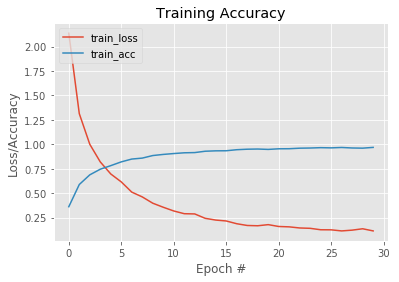

In [247]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
N = len(history.epoch)
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
# plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
# plot the trainingaccuracy
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
# plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left");

Доля верных ответов на всем тесте: 0.94


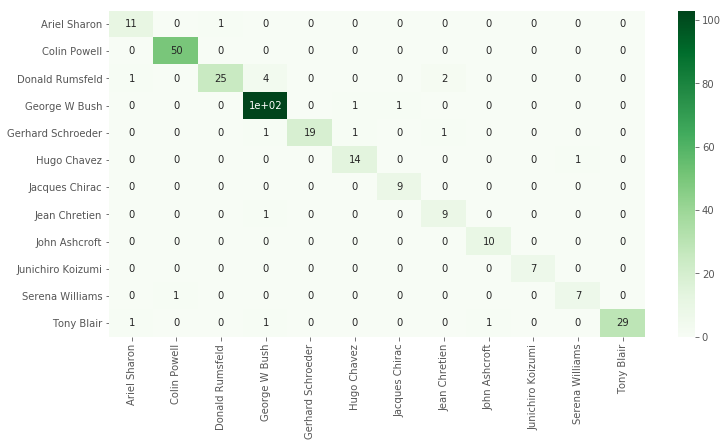

In [248]:
y_pred = model_conv.predict(x_test.reshape(x_test.shape[0], input_shape[0], input_shape[1], 1)).argmax(axis=1)
y_true = y_test_cat.argmax(axis=1)
confusionmatrix = confusion_matrix(y_pred, y_true)

accuracy = accuracy_score(y_pred, y_true)
print('Доля верных ответов на всем тесте: %.2f' % accuracy)

plt.figure(figsize=(12, 6))
sns.heatmap(confusionmatrix, cmap='Greens', annot=True,
            xticklabels=lfw_people.target_names,
            yticklabels=lfw_people.target_names)
plt.show()